# Decision Tree

### Fit
1. Create the root node
2. Using greedy search loop over all features and thresholds to find the best information gain
3. Save the best split feature and split threshold at each node
4. Repeat the steps recursively until stopping criteria (max depth, minimum samples in a node, no class distribution) is met
5. When the leaf node is reached store the most common class label

### Predict
1. Traverse the tree recursively
2. At each node look at the best split feature of the input vector $\mathbf{x}$ and go left or right depending on $\mathbf{x}$[feature_idx] $\leq$ threshold
3. When leaf node is reached return the stored most common class label

### Entropy

$$
\begin{align*}
E &= - \sum_{i}^{N} p(x_i) \log_N{p(x_i)} \\
p(x) &= \frac{\# x}{n} \\
\# x &= \text{number of labels } x \\
n &= \text{number of samples} \\
N &= \text{number of classes}
\end{align*}
$$

### Information gain
$$ \text{IG} = E(\text{parent}) - [\text{weighted average}] \cdot E(\text{children}) $$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def plot_2d_clf_problem(X, y, h=None):
    '''
    Plots a two-dimensional labeled dataset (X,y) and, if function h(x) is given, 
    the decision surfaces.
    '''
    assert X.shape[1] == 2, "Dataset is not two-dimensional"
    if h!=None : 
        # Create a mesh to plot in
        r = 0.03  # mesh resolution
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, r),
                             np.arange(y_min, y_max, r))
        XX=np.c_[xx.ravel(), yy.ravel()]
        try:
            Z_test = h(XX)
            if Z_test.shape == ():
                # h returns a scalar when applied to a matrix; map explicitly
                Z = np.array(list(map(h,XX)))
            else :
                Z = Z_test
        except ValueError:
            # can't apply to a matrix; map explicitly
            Z = np.array(list(map(h,XX)))
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

    # Plot the dataset
    plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.tab20b, marker='o', s=50);

In [3]:
def entropy(y: np.ndarray) -> float:
    """
    Calculates the entropy of target values.

    Parameters
    ----------
    y : numpy.ndarray
        Target values of shape (n_samples,).

    Returns
    -------
    e : float
        Entropy associated with the given target values.
    """
    # Get the probability for each value
    probabilites = np.bincount(y) / len(y)

    # Get the number of unique values (classes)
    classes = len(set(y))

    if classes != 1:
        return -1 * np.sum([p * np.log(p) / np.log(classes) for p in probabilites if p > 0])
    else:
        return 0

class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None) -> None:
        """
        Node for building a decision tree. 
        Each node is a point at which a decision is made.

        Attributes
        ----------
        feature : int
            Index of the feature column which is used as the feature space for the node.

        threshold : float
            Value that best splits the feature space based on information gain.

        left : Node
            Subset of feature space where the values are below or equal to the threshold.

        right: Node
            Subset of feature space where the values are above the threshold.

        value : int
            The target value of the most common class of a node if the stopping criteria is reached.
            If the node has a value then it is a leaf node.
        """
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self) -> bool:
        """
        Method for determining whether a node is a leaf node.
        Node is a leaf node only if it has a value assigned to it.

        Returns
        -------
        result : bool
        """
        return self.value != None
    
class DecisionTree:

    def __init__(self, min_samples_split: int = 2, max_depth: int = 100, n_feats: int = None) -> None:
        """
        Decision Tree classifier.

        Parameters
        ----------
        min_samples_split : int, default=2
            Minimum number of samples required to split a node.

        max_depth : int, default=100
            Maximum depth of the tree.

        n_feats : int, default=None
            Number of features to choose from when performing a node split.

        Attributes
        ----------
        root : Node
            Root node of the tree.
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Build a decision tree.

        Parameters
        ----------
        X : numpy.ndarray
            Training data of shape (n_samples, n_features).

        y : numpy.ndarray
            Target values of shape (n_samples,).

        Returns
        -------
        None
        """
        # Set n_feats
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        # Create root node
        self.root = self._grow_tree(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predict using the decision tree.

        Parameters
        ----------
        X : numpy.ndarray
            Samples of shape (n_samples, n_features).

        Returns
        -------
        y : numpy.ndarray
            Predicted values of shape (n_samples,).
        """
        # Traverse the tree
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x: np.ndarray, node: Node) -> int:
        """
        Helper method for traversing the decision tree recursively.

        Parameters
        ----------
        x : np.ndarray
            Sample of shape (n_features,).

        node : Node
            Node at which the traversal starts.

        Returns
        -------
        value : int
            Value located at the leaf node.
        """
        if node.is_leaf_node():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        
        return self._traverse_tree(x, node.right)

    def _grow_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0) -> Node:
        """
        Helper method for growing the decision tree recursively.

        Parameters
        ----------
        X : numpy.ndarray
            Training data of shape (n_samples, n_features).

        y : numpy.ndarray
            Target values of shape (n_samples,).

        depth : int, default=0
            Current depth of tree.

        Returns
        -------
        node : Node
            Node containing children nodes or a leaf node if the stopping criteria is reached.
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping criteria (leaf node reached)
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        
        # Randomize features
        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        # Search for best information gain and save best split feature and best split threshold
        best_feature, best_threshold = self._best_criteria(X, y, feat_idxs)

        # Split the current node into left and right nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_threshold)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
        
    def _most_common_label(self, y: np.ndarray) -> int:
        """
        Helper method for determining the most common label in an array.

        Parameters
        ----------
        y : np.ndarray
            Target values of shape (n_samples,).

        Returns
        -------
        label : int
            Most common target value.
        """
        counter = Counter(y)
        return counter.most_common(1)[0][0]
    
    def _best_criteria(self, X: np.ndarray, y:np.ndarray, feat_idxs: np.ndarray) -> tuple[int, float]:
        """
        Helper method for determining the best criteria for a node split (feature index and feature threshold).

        Parameters
        ----------
        X : numpy.ndarray
            Training data of shape (n_samples, n_features).

        y : numpy.ndarray
            Target values of shape (n_samples,).

        feat_idxs : numpy.ndarray
            Array of feature indices.

        Returns
        -------
        criteria : tuple[int, float]
            Best feature index and best feature threshold.
        """
        best_gain = -1
        split_idx, split_threshold = None, None

        # Loop through all feature indices
        for feat_idx in feat_idxs:

            # Select the feature column
            X_column = X[:, feat_idx]
            # Get the unique column values to be thresholds
            thresholds = np.unique(X_column)

            # Loop through all thresholds
            for threshold in thresholds:
                
                # Calculate the information gain for the given target values, column and threshold
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    # Store the new best gain, feature index and feature threshold
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = threshold

        return split_idx, split_threshold
    
    def _information_gain(self, y: np.ndarray, X_column: np.ndarray, split_threshold: float) -> float:
        """
        Helper method for calculating information gain.

        Parameters
        ----------
        y : numpy.ndarray
            Target values of shape (n_samples,).
        
        X_column : numpy.ndarray
            Feature column of shape (n_samples,).

        split_threshold : float
            Threshold used for splitting the feature column.

        Returns
        -------
        information_gain : float
        """
        # Calculate entropy of the target values
        parent_entropy = entropy(y)

        # Split the feature column based on the given threshold
        left_idxs, right_idxs = self._split(X_column, split_threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        # Calculate left and right child entropies
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        # Calculate weighted average of left and right child entropies
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        return parent_entropy - child_entropy

    def _split(self, X_column: np.ndarray, split_threshold: float) -> tuple[np.ndarray, np.ndarray]:
        """
        Helper method for splitting the values based on threshold.

        Parameters
        ----------
        X_column : numpy.ndarray
            Feature column of shape (n_samples,).

        split_threshold : float
            Threshold used for splitting the values.

        Returns
        -------
        indices : tuple[numpy.ndarray, numpy.ndarray]
            Left and right indices.
            Left indices are the indices of values below or equal to the threshold.
            Right indices are the indices of values above the threshold.
        """
        left_idxs = np.argwhere(X_column <= split_threshold).flatten()
        right_idxs = np.argwhere(X_column > split_threshold).flatten()
        return left_idxs, right_idxs

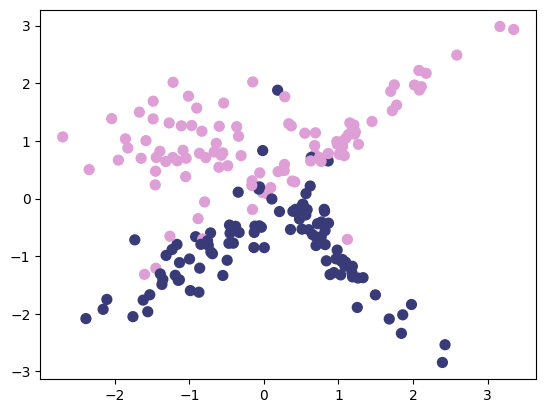

In [4]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=200, n_classes=2, n_features=2, n_informative=2, n_redundant=0)
X_train, y_train = X[:int(len(X)/2)], y[:int(len(X)/2)]
X_test, y_test = X[int(len(X)/2):], y[int(len(X)/2):]
plot_2d_clf_problem(X, y)

Accuracy train: 1.0
Accuracy test: 0.84


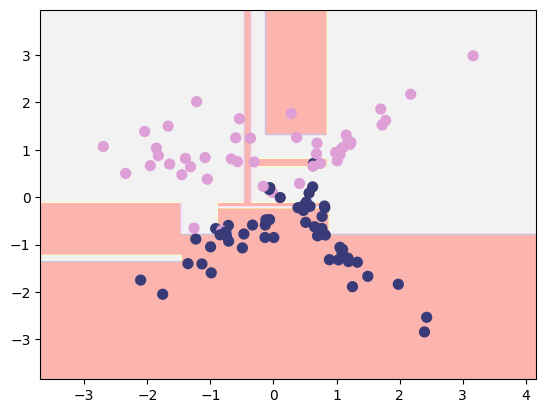

In [5]:
model = DecisionTree()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)
print(f'Accuracy train: {np.mean(y_pred == y_train)}')
y_pred = model.predict(X_test)
print(f'Accuracy test: {np.mean(y_pred == y_test)}')
plot_2d_clf_problem(X_test, y_test, model.predict)

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

data = datasets.load_breast_cancer()
X, y = data['data'], data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [7]:
model = DecisionTree(max_depth=30)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Accuracy: {np.mean(y_pred == y_test)}')

Accuracy: 0.9122807017543859
